Importamos las librerias. Algunas son para el uso de la GPU, otras son para el proyecto

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from PIL import Image
import subprocess
from tensorflow.keras.callbacks import EarlyStopping



2024-04-16 09:04:19.086492: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 09:04:19.086527: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 09:04:19.087832: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-16 09:04:19.095893: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 09:04:19.792898: W tensorflow/compiler/tf2

Para que el programa utilice la VRAM que tiene el sistema y no la RAM de la computadora

In [2]:
def get_gpu_memory():
    """Returns the total memory of the GPU in MB"""
    try:
        result = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=memory.total", "--format=csv,nounits,noheader"], 
            encoding='utf-8')
        return int(result.strip())
    except Exception as e:
        print("Error al obtener la información de la memoria de la GPU:", e)
        return None

# Obtener la cantidad de memoria VRAM disponible en la GPU
total_memory_mb = get_gpu_memory()
if total_memory_mb is not None:
    total_memory_gb = total_memory_mb / 1024
    print("Cantidad total de memoria VRAM en la GPU:", total_memory_gb, "GB")
    
    # Configurar TensorFlow para limitar el uso de memoria GPU
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            # Limitar la memoria GPU al máximo disponible
            tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No se pudo obtener la información de la memoria de la GPU.")

Cantidad total de memoria VRAM en la GPU: 6.0 GB


2024-04-16 09:04:20.754549: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 09:04:20.790340: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 09:04:20.790593: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
import tensorflow as tf
# Verificar si TensorFlow detecta GPU
if tf.config.experimental.list_physical_devices('GPU'):
    print('GPU detectada:')
    for device in tf.config.list_physical_devices('GPU'):
        print(device)
else:
    print('No se detectó GPU. Se utilizará la CPU.')

GPU detectada:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
# Configurar para usar la GPU si está disponible
if tf.config.experimental.list_physical_devices('GPU'):
    # Limitar la cantidad de VRAM a utilizar si es necesario
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)
    else:
        print("No se detectaron GPUs.")


In [5]:
#Check on edit - notebook settings - gpu acceleration
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print ('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2024-04-16 09:04:20.938628: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 09:04:20.938914: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 09:04:20.939091: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Leer la base de datos creada con anterioridad y ver su contenido

In [6]:
df = pd.read_hdf('DB_Hats_Gray.h5')


In [7]:
print(df.shape)


(3720, 2)


In [8]:
df.head()

,Imagen,Etiqueta
0,"[[[254], [253], [249], [252], [252], [252], [2...",TOP HAT
1,"[[[110], [110], [111], [111], [111], [112], [1...",TOP HAT
2,"[[[68], [68], [69], [70], [71], [72], [72], [7...",TOP HAT
3,"[[[255], [255], [255], [255], [255], [255], [2...",TOP HAT
4,"[[[0], [1], [2], [5], [2], [3], [1], [0], [0],...",TOP HAT


In [9]:
df.shape

(3720, 2)

Separamos las caracteristicas y etiquetas

In [10]:
# Separar las características y etiquetas
X = np.array(df['Imagen'])
y = df['Etiqueta']


In [11]:
y.shape

(3720,)

Verificamos el formato, que sea ideal para la CNN

In [12]:
print(df['Imagen'].values[0].shape)

(224, 224, 1)


Dado que el formato de rostro puede ser menor o mayor medida, hay que adaptar todos los datos a un formato. En este caso lo escalamos a 150x150

In [13]:
#for i in range(X.shape[0]):
    #X[i] = np.array(Image.fromarray(X[i]).resize((224,224,1)))

Verificamos el formato 

In [14]:
print(X[0].shape)

(224, 224, 1)


Codificamos el formato de las etiquetas para que estén en 0,1,2,3,4,5...

In [15]:
# Codificar las etiquetas
etiquetas = y.unique()
y_encoded = pd.Categorical(y, categories=etiquetas).codes

Verificamos que se haya transformado a un formato minimo y maximo

In [16]:
print(y_encoded)

[ 0  0  0 ... 19 19 19]


Hacemos los datos de entrenamiento y los de prueba

In [17]:
# Dividir el dataset en conjuntos de entrenamiento y validación
#X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
#X_train, X_val, y_train, y_val = X_train, X_test, y_encoded_train, y_encoded_test
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


Transformar las etiquetas a one_hot. Dependiendo la posición del numero es la etiqueta 

In [18]:
# Convertir las etiquetas a formato one-hot
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)

In [19]:
print(y_val_one_hot)
print("Clases originales:", df['Etiqueta'].unique())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Clases originales: ['TOP HAT' 'PORK PIE' 'ZUCCHETTO' 'GARRISON CAP' 'MOTARBOARD' 'HARD HAT'
 'FOOTBALL HELMET' 'BOATER' 'FEZ' 'BASEBALL CAP' 'BERET' 'SOMBERO'
 'ASCOT CAP' 'DEERSTALKER' 'BICORNE' 'PITH HELMET' 'MILITARY HELMET'
 'SOUTHWESTER' 'BOWLER' 'FEDORA']


Distribución visual de las etiquetas y su clasificacion

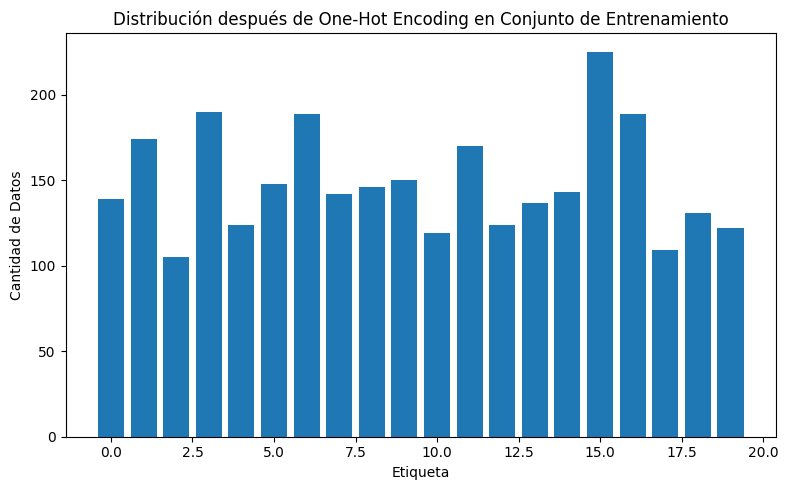

In [20]:
# Visualizar la distribución después de convertir las etiquetas a one-hot
plt.figure(figsize=(8, 5))
plt.bar(np.unique(y_train_one_hot.argmax(axis=1)), np.bincount(y_train_one_hot.argmax(axis=1)), align='center')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de Datos')
plt.title('Distribución después de One-Hot Encoding en Conjunto de Entrenamiento')
plt.tight_layout()
plt.show()

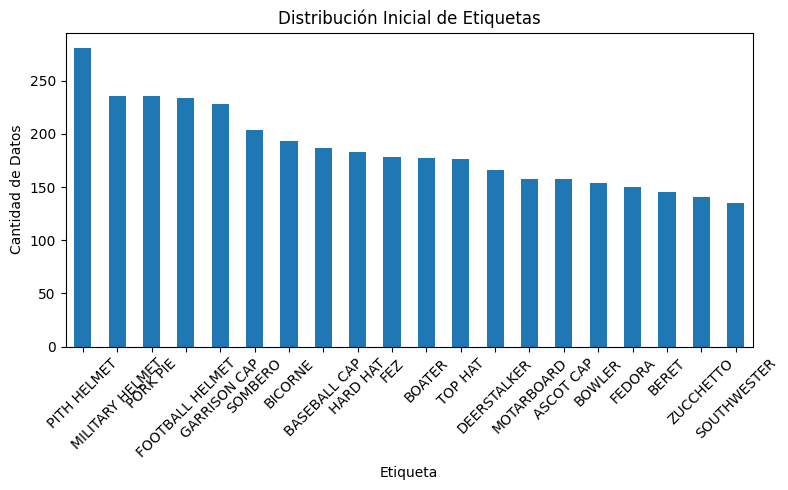

In [21]:
# Visualizar la distribución inicial de etiquetas
plt.figure(figsize=(8, 5))
df['Etiqueta'].value_counts().plot(kind='bar')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de Datos')
plt.title('Distribución Inicial de Etiquetas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Normalizamos los datos de entrenamiento y los de valores para verificar en numpy array

In [22]:
# Convertir las imágenes a arrays numpy y normalizarlas
X_train = np.array([np.array(img) for img in X_train])
X_val = np.array([np.array(img) for img in X_val])

In [23]:
# Cargar las clases desde el archivo
with open('clases.txt', 'r') as f:
    clases = f.readlines()
clases = [c.strip() for c in clases]

BASEBALL CAP
1


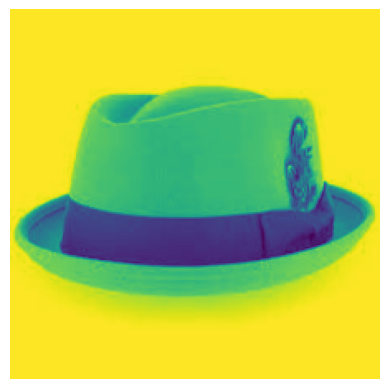

In [24]:
import matplotlib.pyplot as plt
numero_prueba = 10
numero_prueba = numero_prueba*100
indice_predicho = np.argmax(y_train_one_hot[numero_prueba])
print(clases[indice_predicho])
print(y_train[numero_prueba])
imagen_prueba = X_train[numero_prueba]
# Suponiendo que 'imagen' es tu array numpy que contiene la imagen
plt.imshow(imagen_prueba)
plt.axis('off')  # Desactivar los ejes si no son necesarios
plt.show()


Todos los datos de entrenamiento los ponemos en tipo flotante 32 y lo dividimos en 255 (que es formato de imagen), esto para normalizar del 0 al 1

In [25]:
# Normalizar las imágenes dividiendo por 255.0
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

In [26]:
X_train.shape

(2976, 224, 224, 1)

Generamos infinidad de imagenes (Muchas imagenes. No son infinitas). Definimos los patrones para generar más imagenes y que el modelo no se sobre ajuste

In [27]:
# Definir el generador de imágenes para aumentar el dataset de entrenamiento
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Aqui lo aumentamos.

In [28]:
# Aumentar el dataset de entrenamiento utilizando el generador de imágenes
train_generator = datagen.flow(X_train, y_train_one_hot, batch_size=28)



Todo el modelo definido

In [29]:


# Definir el modelo de red neuronal convolucional (CNN)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(224, 224,1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(len(etiquetas), activation='softmax')  # Capa de salida con activación softmax
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

2024-04-16 09:04:31.543445: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 09:04:31.543944: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 09:04:31.544252: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [30]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Compilamos el modelo.

In [31]:
"""""""""

# Definir el callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo con el callback de EarlyStopping
with tf.device('/device:GPU:0'):
    history = model.fit(train_generator,
                        epochs=200,
                        validation_data=(X_val, y_val_one_hot),
                        verbose=1,
                        callbacks=[early_stopping]
                        )
"""""""""

"\n\n# Definir el callback EarlyStopping\nearly_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)\n\n# Entrenar el modelo con el callback de EarlyStopping\nwith tf.device('/device:GPU:0'):\n    history = model.fit(train_generator,\n                        epochs=200,\n                        validation_data=(X_val, y_val_one_hot),\n                        verbose=1,\n                        callbacks=[early_stopping]\n                        )\n"

In [32]:

    
# Entrenar el modelo con el callback de TensorBoard

with tf.device('/device:GPU:0'):
    history = model.fit(train_generator,
                            epochs=200,
                            validation_data=(X_val, y_val_one_hot),
                            verbose=1,
                            )


Epoch 1/200


2024-04-16 09:04:32.630360: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 09:04:34.865108: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f09151a67d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-16 09:04:34.865131: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti with Max-Q Design, Compute Capability 7.5
2024-04-16 09:04:34.891922: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1713283475.027130   61190 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


107/107 [==============================] - 16s 99ms/step - loss: 2.9495 - accuracy: 0.0924 - val_loss: 2.7674 - val_accuracy: 0.1505
Epoch 2/200
107/107 [==============================] - 8s 78ms/step - loss: 2.7152 - accuracy: 0.1704 - val_loss: 2.4302 - val_accuracy: 0.2621
Epoch 3/200
107/107 [==============================] - 8s 76ms/step - loss: 2.4952 - accuracy: 0.2403 - val_loss: 2.2411 - val_accuracy: 0.3145
Epoch 4/200
107/107 [==============================] - 9s 83ms/step - loss: 2.3979 - accuracy: 0.2755 - val_loss: 2.2708 - val_accuracy: 0.3172
Epoch 5/200
107/107 [==============================] - 9s 81ms/step - loss: 2.2971 - accuracy: 0.3058 - val_loss: 2.0892 - val_accuracy: 0.3952
Epoch 6/200
107/107 [==============================] - 9s 81ms/step - loss: 2.2371 - accuracy: 0.3179 - val_loss: 1.9392 - val_accuracy: 0.4301
Epoch 7/200
107/107 [==============================] - 9s 81ms/step - loss: 2.1872 - accuracy: 0.3300 - val_loss: 1.9230 - val_accuracy: 0.4261
Epo

KeyboardInterrupt: 

Entrenamos el modelo

Guardamos el modelo

In [ ]:
# Guardar el modelo
model.save('M_hats_0904_200E.h5')

/home/waldos/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Obtenemos predicciones del conjunto de validacion

In [ ]:
# Evaluar el modelo
with tf.device('/CPU:0'):
    test_loss, test_acc = model.evaluate(X_val, y_val_one_hot)
    print(f'Precisión en el conjunto de pruebas: {test_acc}')
    print(f'Loss en el conjunto de pruebas: {test_loss}')

24/24 [==============================] - 7s 282ms/step - loss: 1.3281 - accuracy: 0.7083
Precisión en el conjunto de pruebas: 0.7083333134651184
Loss en el conjunto de pruebas: 1.3281235694885254


In [ ]:
# Obtener las predicciones del conjunto de validación
with tf.device('/CPU:0'):
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

24/24 [==============================] - 7s 273ms/step


Tabla graficamente de la precision y perdida del modelo a partir de las epocas

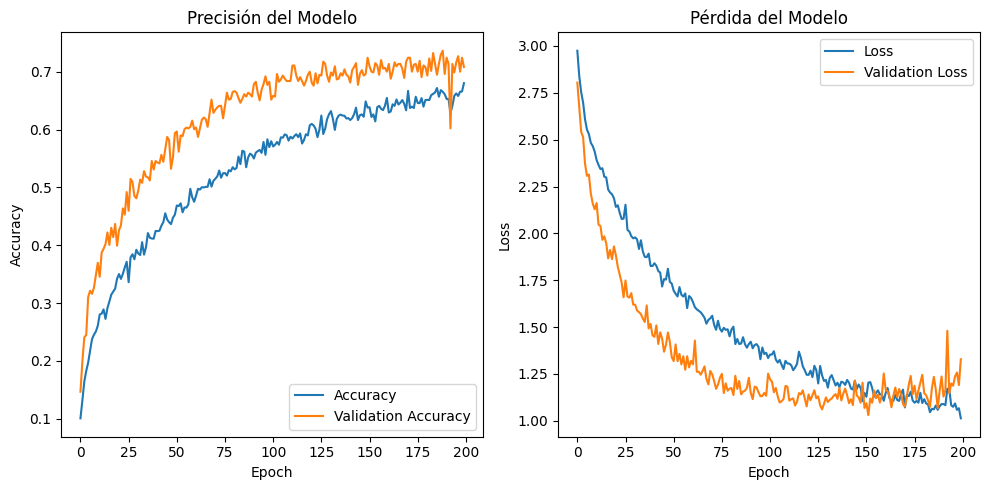

In [ ]:
# Mostrar la precisión y pérdida del modelo
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Precisión del Modelo')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Pérdida del Modelo')

plt.tight_layout()
plt.show()

Matriz de confusion

In [ ]:
# Calcular la matriz de confusión
conf_mat = confusion_matrix(np.argmax(y_val_one_hot, axis=1), y_pred_classes)

Visualizacion de la matriz de confusion mediante mapa de calor

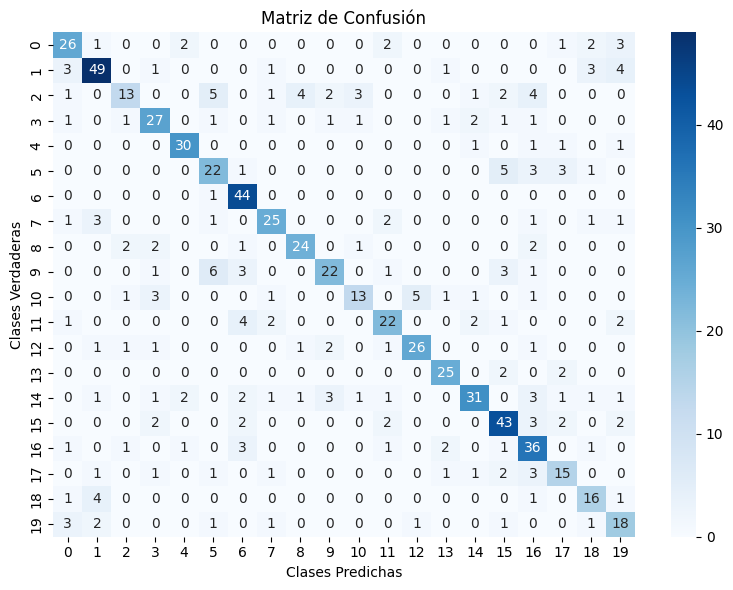

In [ ]:
# Visualizar la matriz de confusión como un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Verdaderas')
plt.title('Matriz de Confusión')
plt.tight_layout()
plt.show()

In [ ]:
with open('clases.txt', 'r') as f:
    clases = f.readlines()
clases = [c.strip() for c in clases]
x = 0
for i in clases:
    print(str(x)+"-"+str(i))
    x +=1

0-ASCOT CAP
1-BASEBALL CAP
2-BERET
3-BICORNE
4-BOATER
5-BOWLER
6-DEERSTALKER
7-FEDORA
8-FEZ
9-FOOTBALL HELMET
10-GARRISON CAP
11-HARD HAT
12-MILITARY HELMET
13-MOTARBOARD
14-PITH HELMET
15-PORK PIE
16-SOMBRERO
17-SOUTHWESTER
18-TOP HAT
19-ZUCCHETTO
